# Modeling translational efficiency and mRNA stability with Gaussian processes: an application to synthetic gene design


### Written by Javier Gonzalez (j.h.gonzalez@sheffield.ac.uk), University of Sheffield.

## Table of contents
=====================================================================================================
1. **Problem description and preliminar considerations**

2. **Data loading and preprocessing**

3. **Descriptive data analysis**

4. **Gaussian process model for the translational efficiency of mammalian cells**

5. **Gaussian process model for the mRNA stability of mammalian cells**

6. **Gene design tool: Using the models to design CMV promoter-SEAP**

6. **Conclusions**

=====================================================================================================

## 1. Problem description and prelimiar considerations

###Outputs of the analysis:

* **Model 1**: Model to predict the translational efficiency of a gene (given 5'utr + cds + 3'utr)

* **Model 2**: Model to predict the mRNA stability of a gene (given 5'utr + cds + 3'utr)

* **Application**: Gene design tool able to produce a full gene (5'utr + cds + 3'utr) given a protein to be produced and certain translational efficiency.

### Considerations:

* The models are estimated using the data set available in (Schwuanhauser et all. 2012).

* The outputs of the model are the translation rates and mRNAs half lifes reported in the previos paper.

* We used Gaussaian process regression based on GPy.

* The models use as input a set of biologically relevant features that are known to affect the translational efficiency and mRNA stability. The type of featues used can be classified in 5 types:


*Sequence lengths*
 *	Coding sequence length.
 *	5’UTR length.
 *	3’UTR length.

* Nucleotide frequencies and properties*
 *	3’UTR free folding energy. 
 *	5’UTR free folding energy. 
 *	coding region free folding energy.
 *	Free folding energy at the end of 5’UTR.
 *	Free folding energy the first 40 nucleotides of the coding region.
 *	Best local secondary structure for 3'UTR and 5'UTR with window size 40, 60.
 *	Best local normalized secondary str. for 3'UTR and 5'UTR with window size 40, 60.
 *	Best local  randomized secondary str. for 3'UTR and 5'UTR with window size 40, 60.

*Codons and aminoacid frequencies and properties*
 *	Codons usage in coding region. 
 *	Codons usage in the first 30-50 codons in the coding region.
 *	Amino-acid frequencies. 
 *	Relative synonymous codon usage (point 19).
 *	**Codon context (pairs of codons).**

*Specific motifs frequency*
 *	AT content.
 *	GC ratio.
 *	GC content in coding region.
 *	GC content in the whole gene.
 *	GC content in starting coding region.
 *	GC content in codon positions 1, 2 and 3.
 *	AUG (atg) frequency in 5’UTR (uORF frequency in 5’UTR).
 *	Number of A’s at the beginning of the 5’UTR.
 *	Number of Polyadenylation sites/3’UTR (AUAAA motif).
 *	Motif RYMRMVAUGGC. 
 *  **5'TOP iniatiation motifs.**
 *  **5'TOP elongation motifs.**
 *  **5'TOP rna binding motifs.**
 *  **5'TOP ribosomal protein motifs.**
 *  **AU-rich elements (motif WWWU(AUUUA)UUUW where W is A or U).**
 *  **Kozak consensus sequence and variants.**
 *  **Glycosylation consensus sequence and variants.**
 
 
*Codon bias indices*
 *	Codon adaptation index in coding region.
 *	Codon adaptation index in first 30-50 codons.
 *	Codon bias index (relative codon bias sequence RCBS)

## 2. Data loading and pre-processing

In [1]:
%pylab inline
import numpy as np
import GPy
from matplotlib import pyplot as plt
import scipy.stats.stats 
from numpy import genfromtxt
from pandas import DataFrame, concat
import pandas as pd
from matplotlib.pyplot import *
from scipy.stats.stats import pearsonr as cor
from sklearn.preprocessing import scale
from pylab import pcolor, show, colorbar, xticks, yticks

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load features and extract what we need
df_features_all   = pd.read_csv('./features_mouse_processing/processed/features_genes.csv',sep=' ')
df_features_all   = df_features_all.drop('index',1)

# In principle we don't use the Codon context, so we only keep the rest of the features.
df_ids       = df_features_all.iloc[:,0:1] 
df_features1 = df_features_all.iloc[:,1:129] 
df_cc        = df_features_all.iloc[:,129:4225]
df_features2 = df_features_all.iloc[:,4225:]

df_features = concat([df_ids, df_features1,df_features2], axis=1)
df_features   = df_features.replace([np.inf, -np.inf], np.nan)
df_features   = df_features.dropna(0)

In [3]:
## load and merge the datasets that we need for the model
# load translation rates
df_rates      = pd.read_csv('./data_mouse/translation.csv', sep='\t').dropna()

# load rna_hl
df_rna_hl     = pd.read_csv('./data_mouse/rna_hl.csv', sep='\t').dropna()

# load RNA
df_rna     = pd.read_csv('./data_mouse/rna.csv', sep='\t').dropna()

# full dataset (with genes where full information is available)
df_full0      = pd.merge(df_rates, df_features, on='gene_ID', how='inner')
df_full1      = pd.merge(df_rna_hl, df_full0, on='gene_ID', how='inner')
df_full       = pd.merge(df_rna, df_full1, on='gene_ID', how='inner')
df_full

,gene_ID,RNA_r1,RNA_r2,RNA_av,mrna_hl_r1,mrna_hl_r2,mrna_hl_av,translation_r1,translation_r2,translation_av,...,best_randomized_sec_structure40_5utr,best_local_sec_structure60_5utr,best_normalized_sec_structure60_5utr,best_randomized_sec_structure60_5utr,TOP_iniatiation_5utr,TOP_elongation_5utr,TOP_rnabinding_5utr,TOP_ribosomal_proteins,AREs_5utr,gc_content_total
0,ENSMUST00000042235,3605.71,2892.61,3229.54,14.96,20.47,17.50,274.90,370.49,319.13,...,2.018350,-18.700001,-1.000000,1.250000,2,1,1,1,0,0.474359
1,ENSMUST00000034756,626.16,635.25,630.69,13.89,16.41,15.10,1116.26,958.02,1034.12,...,0.701482,-23.000000,-1.000000,3.666668,2,0,1,1,0,0.530753
2,ENSMUST00000018437,880.15,544.47,692.25,15.48,16.62,16.04,751.44,995.29,864.81,...,1.800119,-20.299999,-1.000000,6.151516,0,0,0,1,0,0.554007
3,ENSMUST00000034834,1140.45,1041.71,1089.96,18.96,23.27,21.00,441.13,463.23,452.05,...,-1.358682,-36.700001,-1.504181,-0.555816,0,0,0,1,0,0.576891
4,ENSMUST00000031383,215.59,127.73,165.94,16.24,15.57,15.90,2399.73,2707.59,2549.02,...,-0.125441,-29.900000,-1.260904,0.447467,2,0,0,2,0,0.471182
5,ENSMUST00000022894,75.92,68.56,72.15,14.64,8.43,11.11,5985.41,6606.55,6288.32,...,0.108735,-20.500000,-1.524012,0.982993,5,0,1,4,0,0.455596
6,ENSMUST00000080300,7.50,17.13,11.34,2.97,3.29,3.13,54533.58,13391.25,27023.56,...,-17.400000,-17.400000,-17.400000,-17.400000,0,0,0,0,0,0.459736
7,ENSMUST00000024739,938.35,860.50,898.58,14.76,24.69,19.09,507.17,674.79,585.01,...,8.428573,-24.200001,-24.200001,-24.200001,1,0,0,0,0,0.510317
8,ENSMUST00000067664,282.45,218.80,248.60,15.31,20.59,17.75,1535.11,1801.04,1662.76,...,3.450556,-14.600000,-1.000000,105.000267,0,0,0,1,0,0.439048
9,ENSMUST00000005051,395.05,381.78,388.36,19.62,29.20,23.93,1017.01,960.57,988.39,...,0.841519,-17.100000,-1.011946,8.735423,2,0,1,4,0,0.510193


In [4]:
# we check the dimensions of the problem
df_full.shape

(2340, 267)

## 1.-Data selection

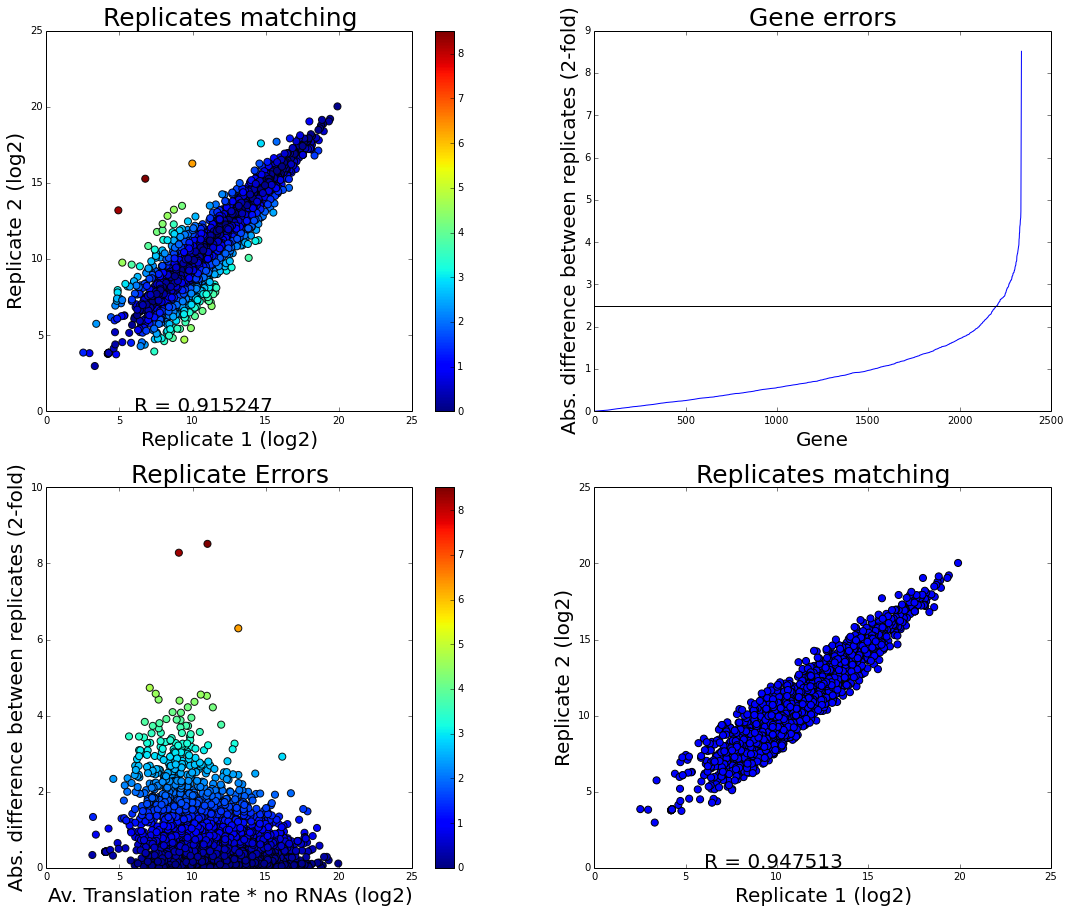

In [5]:
## select the best data from the set
errors = abs(np.log2(df_full['translation_r1']*df_full['RNA_r1'])-np.log2(df_full['translation_r2']*df_full['RNA_r2']))
threshold = 2.5
sel_gene = errors < threshold
df_full_sel = df_full[sel_gene]
df_full_sel.to_csv('data_set')

# Correlation between replicates
cor_replicates = cor(log2(df_full['translation_r1']*df_full['RNA_r1']),np.log2(df_full['translation_r2']*df_full['RNA_r2']))[0]
cor_replicates_clean = cor(log2(df_full['translation_r1']*df_full['RNA_r1'])[sel_gene],np.log2(df_full['translation_r2']*df_full['RNA_r2'])[sel_gene])[0]


# Plot of all the features
plt.figure(figsize=(18,15))
plt.subplot(221)
plt.scatter(log2(df_full['translation_r1']*df_full['RNA_r1']),np.log2(df_full['translation_r2']*df_full['RNA_r2']),c=errors,s=50,alpha=25)
plt.xlabel('Replicate 1 (log2)',fontsize=20)
plt.ylabel('Replicate 2 (log2) ',fontsize=20)
plt.title('Replicates matching',fontsize=25)
plt.text(6,0,'R = %2f' % cor_replicates,fontsize=20)
plt.colorbar()

plt.subplot(222)
plt.plot(sorted(errors),'b-')
plt.xlabel('Gene',fontsize=20)
plt.ylabel('Abs. difference between replicates (2-fold)',fontsize=20)
plt.title('Gene errors',fontsize=25)
plt.axhline(y=threshold, xmin=0.0, xmax=250, linewidth=1, color = 'k')

plt.subplot(223)
plt.scatter(np.log2(df_full['translation_av']*df_full['RNA_av']),errors.astype('float64'),c=errors,s=50,alpha=25)
plt.xlabel('Av. Translation rate * no RNAs (log2)',fontsize=20)
plt.ylabel('Abs. difference between replicates (2-fold) ',fontsize=20)
plt.title('Replicate Errors',fontsize=25)
plt.ylim(0, 10 )
plt.colorbar()

plt.subplot(224)
plt.scatter(log2(df_full['translation_r1']*df_full['RNA_r1'])[sel_gene],np.log2(df_full['translation_r2']*df_full['RNA_r2'])[sel_gene],s=50)
plt.xlabel('Replicate 1 (log2)',fontsize=20)
plt.ylabel('Replicate 2 (log2) ',fontsize=20)
plt.title('Replicates matching',fontsize=25)
plt.text(6,0,'R = %2f' % cor_replicates_clean,fontsize=20)

In [7]:
df_full_sel.shape

(2206, 267)

## 2.- Descriptive analysis

array([[ 1.      ,  0.180988],
       [ 0.180988,  1.      ]])

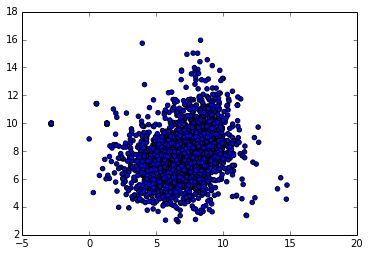

In [6]:
## create matrices for the outputs of the model
Y_translation    = df_full_sel.reset_index()['translation_av'].astype('Float64')
Y_mrna_hl        = df_full_sel.reset_index()['mrna_hl_av'].astype('Float64')
Y_mrna           = df_full_sel.reset_index()['RNA_r1'].astype('Float64')

plt.scatter(log2(Y_translation) ,log2(Y_mrna_hl*Y_mrna) )
np.corrcoef(log2(Y_translation) ,log2(Y_mrna_hl*Y_mrna) )

In [10]:
'''
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
'''
def pareto_frontier(Xs, Ys, maxX = True, maxY = True):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

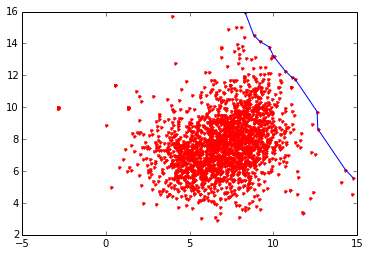

In [11]:
p_front = pareto_frontier(log2(Y_translation) ,log2(Y_mrna_hl*Y_mrna) , maxX = True, maxY = True) 
# Plot a scatter graph of all results
plt.plot(log2(Y_translation) ,log2(Y_mrna_hl*Y_mrna),'r.' )
# Then plot the Pareto frontier on top
plt.plot(p_front[0], p_front[1])
plt.show()

In [8]:
## Design matrix and vector of labels of the genes
X0               = df_full_sel.reset_index().values[:,11:].astype('Float64')

## Scale the input variables and test that we don't have any NA's
X = scale(X0,0)

## Labels
features_labels  = df_full_sel.columns[10:]
gene_labels      = df_full_sel.reset_index()['gene_ID']

In [9]:
## Log transformations and reshape
N                   = X.shape[0] 
Y_translation_log   = np.log2(Y_translation).reset_index().values[:,1].astype('Float64').reshape(N,1)
Y_mrna_hl_log       = np.log2(Y_mrna_hl).reset_index().values[:,1].astype('Float64').reshape(N,1)
Y_mrna_log          = np.log2(Y_mrna).reset_index().values[:,1].astype('Float64').reshape(N,1)
Y_transeff_log      = np.log2(Y_mrna).reset_index().values[:,1].astype('Float64').reshape(N,1)

<img src="model.jpeg">

## 4. Gaussian process model for the translational efficiency of mammalian cells

In [147]:
# Select training and test data
np.random.seed(123)
Ntrain = 1500
Ntest =  X.shape[0] - Ntrain
myRange = range(N)
np.random.shuffle(myRange)

# Index of the training and test genes
sel_train = myRange[0:(Ntrain)]
sel_test  = myRange[Ntrain:N]

# Dimension of the input and ARD
input_dim = X.shape[1]

In [189]:
# kernels and model
K1 = GPy.kern.Bias(input_dim)
K2 = GPy.kern.Linear(input_dim)
K3 = GPy.kern.RBF(input_dim,ARD=True)

In [190]:
# multi-output model
lcm = GPy.util.multioutput.LCM(input_dim=input_dim,num_outputs=2,kernels_list = [K1,K2,K3])
model = GPy.models.GPCoregionalizedRegression([X[sel_train,],X[sel_train,]],[Y_translation_log[sel_train,],Y_mrna_hl_log[sel_train,]],kernel=lcm)
model['.*ICM.*var'].unconstrain()
#model['.*ICM0.*var'].constrain_fixed(1.)
model['.*ICM0.*W'].constrain_fixed(0)
model['.*ICM1.*var'].constrain_fixed(1.)
model['.*ICM1.*W'].constrain_fixed(0)
model['.*ICM2.*var'].constrain_fixed(1.)
model.optimize(optimizer='bfgs', max_iters=1000, messages=1)

In [192]:
model

gp.,Value,Constraint,Prior,Tied to
add.ICM0.bias.variance,7.26980806501,,,
add.ICM0.B.W,"(2, 1)",fixed,,
add.ICM0.B.kappa,"(2,)",+ve,,
add.ICM1.linear.variances,1.0,fixed,,
add.ICM1.B.W,"(2, 1)",fixed,,
add.ICM1.B.kappa,"(2,)",+ve,,
add.ICM2.rbf.variance,1.0,fixed,,
add.ICM2.rbf.lengthscale,"(257,)",+ve,,
add.ICM2.B.W,"(2, 1)",,,
add.ICM2.B.kappa,"(2,)",+ve,,


(0, 260)

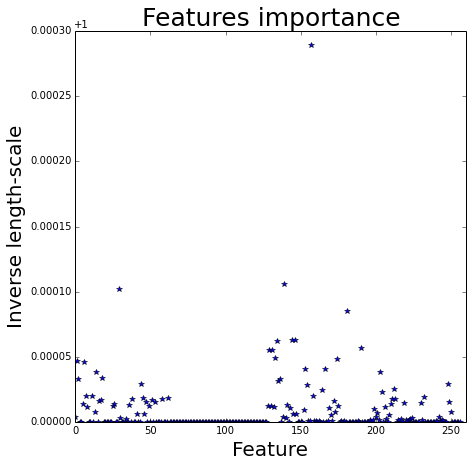

In [193]:
# Plot of all the features
plt.figure(figsize=(7,7))
plt.plot(model.add.ICM2.rbf.lengthscale,'b*')
plt.xlabel('Feature',fontsize=20)
plt.ylabel('Inverse length-scale',fontsize=20)
plt.title('Features importance',fontsize=25)
plt.xlim(0,260)


In [195]:
# List of most influential features
idx = model.add.ICM2.rbf.lengthscale > 0.01
dd = {'weight': model.add.ICM2.rbf.lengthscale,
      'feature':features_labels}

selected_features_translation = DataFrame(dd) 

In [196]:
# features sorted by influence
selected_features_translation.sort(['weight'],ascending =0)

,feature,weight
157,ctc_rs,1.000289
139,agt_rs,1.000106
29,ctc,1.000102
181,tcc_rs,1.000085
146,cag_rs,1.000063
144,caa_rs,1.000063
134,acg_rs,1.000062
190,ttg_rs,1.000057
129,aac_rs,1.000055
131,aat_rs,1.000055


In [197]:
ymeta=np.vstack([ np.zeros((Ntest,1)), np.ones((Ntest,1))]).astype(int)
newX=np.hstack( [ np.vstack([X[sel_test],X[sel_test]]), ymeta]  )
prediction_test=model.predict(newX,Y_metadata={'output_index':ymeta},full_cov=True)

In [198]:
ymeta_old=np.vstack([ np.zeros((Ntrain,1)), np.ones((Ntrain,1))]).astype(int)
oldX=np.hstack( [ np.vstack([X[sel_train],X[sel_train]]), ymeta_old]  )
prediction_train = model.predict(oldX,Y_metadata={'output_index':ymeta_old},full_cov=True)

In [199]:
prediction_train_translation = prediction_train[0][0:Ntrain]
prediction_test_translation  = prediction_test[0][0:Ntest]

In [200]:
prediction_train_mrna_hl = prediction_train[0][Ntrain:]
prediction_test_mrna_hl  = prediction_test[0][Ntest:]

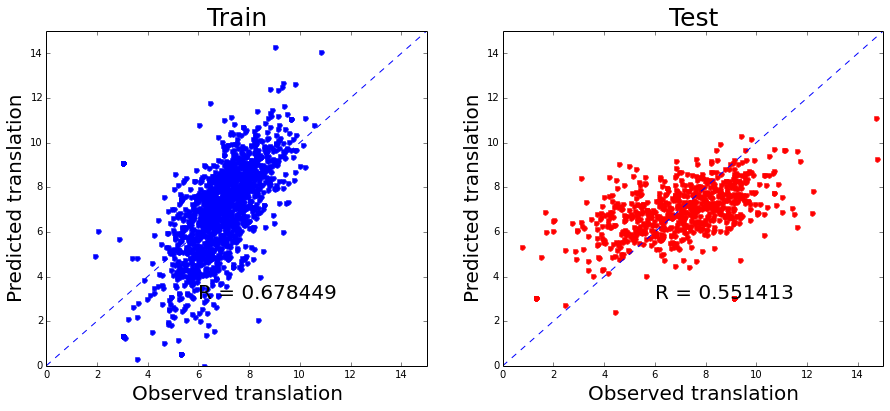

In [201]:
cor_train_translation = cor(prediction_train_translation,Y_translation_log[sel_train,])[0]
cor_test_translation = cor(prediction_test_translation,Y_translation_log[sel_test,])[0]

# Train data
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(prediction_train_translation,Y_translation_log[sel_train,],'b.',markersize=10)
plt.xlabel('Observed translation',fontsize=20)
plt.ylabel('Predicted translation',fontsize=20)
plt.title('Train',fontsize=25)
plt.xlim(0, 15)
plt.ylim(0,  15)
plt.plot(np.linspace(0,16,100), np.linspace(0,16,100), 'b--')
plt.text(6,3,'R = %2f' % cor_train_translation,fontsize=20)


# Test data
plt.subplot(122)
plt.plot(Y_translation_log[sel_test,],prediction_test_translation,'r.',markersize=10)
plt.title('Test',fontsize=25)
plt.xlabel('Observed translation',fontsize=20)
plt.ylabel('Predicted translation',fontsize=20)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.plot(np.linspace(0,16,100), np.linspace(0,16,100), 'b--')
plt.text(6,3,'R = %2f' % cor_test_translation,fontsize=20)

In [185]:
cor_train_mrna_hl = cor(prediction_train_mrna_hl,Y_mrna_hl_log[sel_train,])[0]
cor_test = cor(prediction_test_mrna_hl,Y_mrna_hl_log[sel_test,])[0]


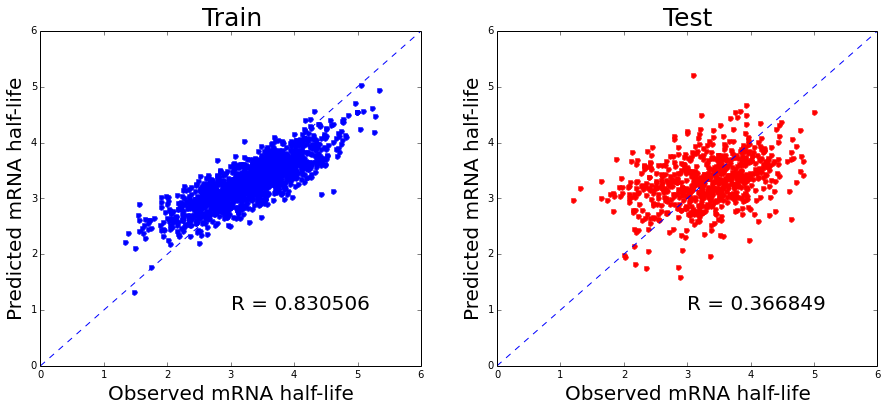

In [186]:
cor_train_mrna_hl = cor(prediction_train_mrna_hl,Y_mrna_hl_log[sel_train,])[0]
cor_test_mrna_hl = cor(prediction_test_mrna_hl,Y_mrna_hl_log[sel_test,])[0]

# Train data
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(Y_mrna_hl_log[sel_train,],prediction_train_mrna_hl,'b.',markersize=10)
plt.xlabel('Observed mRNA half-life',fontsize=20)
plt.ylabel('Predicted mRNA half-life',fontsize=20)
plt.title('Train',fontsize=25)
plt.xlim(0, 6)
plt.ylim(0,  6)
plt.plot(np.linspace(0,16,100), np.linspace(0,16,100), 'b--')
plt.text(3,1,'R = %2f' % cor_train_mrna_hl,fontsize=20)


# Test data
plt.subplot(122)
plt.plot(Y_mrna_hl_log[sel_test,],prediction_test_mrna_hl,'r.',markersize=10)
plt.title('Test',fontsize=25)
plt.xlabel('Observed mRNA half-life',fontsize=20)
plt.ylabel('Predicted mRNA half-life',fontsize=20)
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.plot(np.linspace(0,16,100), np.linspace(0,16,100), 'b--')
plt.text(3,1,'R = %2f' % cor_test_mrna_hl,fontsize=20)

In [202]:
influence_cds = sum(abs(selected_features_translation['weight'][:230]))
influence_3utr = sum(abs(selected_features_translation['weight'][230:240]))
influence_5utr = sum(abs(selected_features_translation['weight'][240:256]))
influence_global = sum(abs(selected_features_translation['weight'][256:]))

(0, 7)

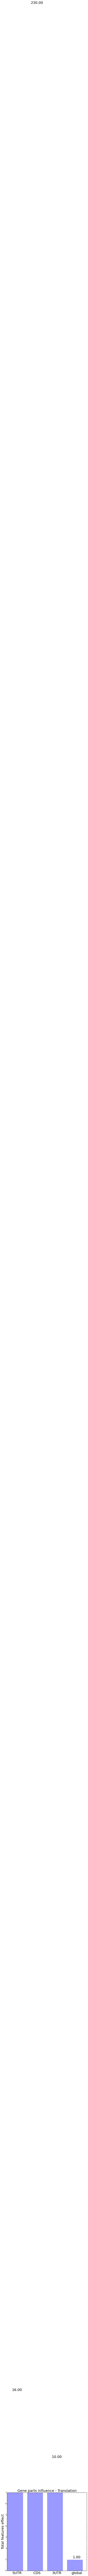

In [203]:
from pylab import *
inf = [influence_5utr, influence_cds,influence_3utr,influence_global]
labels = ['5UTR','CDS','3UTR','global']
n = 4
index = np.arange(n)

plt.figure(figsize=(18,8))
plt.subplot(121)
bar(index, inf , facecolor='#9999ff', edgecolor='white')
for x,y in zip(index,inf):
    text(x+0.5, y+0.05, '%.2f' % y, ha='center', va= 'bottom',fontsize=20)
plt.title('Gene parts influence - Translation',fontsize=20)
plt.xticks([0.5,1.5,2.5,3.5],labels,fontsize=20)
plt.ylabel('Total features effect',fontsize=20)
plt.ylim(0, 7)

## 6. Gene design tool: Using the models to design CMV promoter-SEAP

In [ ]:
# multi-output model
lcm = GPy.util.multioutput.LCM(input_dim=input_dim,num_outputs=2,kernels_list = [K1,K2,K3])
model_final = GPy.models.GPCoregionalizedRegression([X[sel_train,],X[sel_train,]],[Y_translation_log[sel_train,],Y_mrna_hl_log[sel_train,]],kernel=lcm)
model_final['.*ICM.*var'].unconstrain()
#model['.*ICM0.*var'].constrain_fixed(1.)
model_final['.*ICM0.*W'].constrain_fixed(0)
model['.*ICM1.*var'].constrain_fixed(1.)
model['.*ICM1.*W'].constrain_fixed(0)
model['.*ICM2.*var'].constrain_fixed(1.)
model.optimize(optimizer='bfgs', max_iters=1000, messages=1)
model_final

In [204]:
# Selection of the best 5UTR in terms of the translational efficiency
scores_5utr = np.dot(X[:,240:256],selected_features_translation.reset_index()['influence'].astype('Float64').reshape(257,1)[240:256])
scores_3utr = np.dot(X[:,230:240],selected_features_translation.reset_index()['influence'].astype('Float64').reshape(257,1)[230:240])

KeyError: 'influence'

In [16]:
# Selection of the best 5UTR
df_full_sel.reset_index(drop=True)['gene_ID'][argmax(scores_5utr)]


'ENSMUST00000058470'

In [17]:
# Selection of the best 3UTR
df_full_sel.reset_index(drop=True)['gene_ID'][argmax(scores_3utr)]

'ENSMUST00000050201'

In [205]:
## Load functions for gene design
from functions import *

ImportError: No module named RNA

In [19]:
## original 5utr
utr5_cmv = 'agatcgcctggagacgccatccacgctgttttgacctccatagaagacgaattcgcccacc'

In [20]:
## original 3utr
utr3_cmv = 'taagatacattgatgagtttggacaaaccacaactagaatgcagtgaaaaaaatgctttatttgtgaaatttgtgatgctattgctttatttgtaaccattataagctgcaataaacaagttaacaacaa'


In [21]:
## best 5utr (taken from 'ENSMUST00000000804')
utr5_best = 'GTAGCAGTCCTCCGAGTCGGTATATAAGGTCGGTGGCCGCGCGGTGCGCTTCAAAGCCGCAGTTCTCCCGTGAGAGGGCCTTTGCGGTAGAGGCAGCCTTTGCTCAGCAGCGGAAGACTCCGATTTCTCGGTACTCTTCAGGG'


In [22]:
## best 3utr (taken from ENSMUST00000041364)
utr3_best = 'ATTGTCTTGTAATGTAGCAA'

In [23]:
## Coding Region
coding_region_cmv = 'atgctgctgctgctgctgctgctgggcctgaggctacagctctccctgggcatcatcccagttgaggaggagaacccggacttctggaaccgcgaggcagccgaggccctgggtgccgccaagaagctgcagcctgcacagacagccgccaagaacctcatcatcttcctgggcgatgggatgggggtgtctacggtgacagctgccaggatcctaaaagggcagaagaaggacaaactggggcctgagatacccctggccatggaccgcttcccatatgtggctctgtccaagacatacaatgtagacaaacatgtgccagacagtggagccacagccacggcctacctgtgcggggtcaagggcaacttccagaccattggcttgagtgcagccgcccgctttaaccagtgcaacacgacacgcggcaacgaggtcatctccgtgatgaatcgggccaagaaagcagggaagtcagtgggagtggtaaccaccacacgagtgcagcacgcctcgccagccggcacctacgcccacacggtgaaccgcaactggtactcggacgccgacgtgcctgcctcggcccgccaggaggggtgccaggacatcgctacgcagctcatctccaacatggacattgacgtgatcctaggtggaggccgaaagtacatgtttcgcatgggaaccccagaccctgagtacccagatgactacagccaaggtgggaccaggctggacgggaagaatctggtgcaggaatggctggcgaagcgccagggtgcccggtatgtgtggaaccgcactgagctcatgcaggcttccctggacccgtctgtgacccatctcatgggtctctttgagcctggagacatgaaatacgagatccaccgagactccacactggacccctccctgatggagatgacagaggctgccctgcgcctgctgagcaggaacccccgcggcttcttcctcttcgtggagggtggtcgcatcgaccatggtcatcatgaaagcagggcttaccgggcactgactgagacgatcatgttcgacgacgccattgagagggcgggccagctcaccagcgaggaggacacgctgagcctcgtcactgccgaccactcccacgtcttctccttcggaggctaccccctgcgagggagctccatcttcgggctggcccctggcaaggcccgggacaggaaggcctacacggtcctcctatacggaaacggtccaggctatgtgctcaaggacggcgcccggccggatgttaccgagagcgagagcgggagccccgagtatcggcagcagtcagcagtgcccctggacgaagagacccacgcaggcgaggacgtggcggtgttcgcgcgcggcccgcaggcgcacctggttcacggcgtgcaggagcagaccttcatagcgcacgtcatggccttcgccgcctgcctggagccctacaccgcctgcgacctggcgccccccgccggcaccaccgacgccgcgcacccgggttactctagagtcggggcggccggccgcttcgagcagacatga'
coding_region_cmv_noatg = 'ctgctgctgctgctgctgctgggcctgaggctacagctctccctgggcatcatcccagttgaggaggagaacccggacttctggaaccgcgaggcagccgaggccctgggtgccgccaagaagctgcagcctgcacagacagccgccaagaacctcatcatcttcctgggcgatgggatgggggtgtctacggtgacagctgccaggatcctaaaagggcagaagaaggacaaactggggcctgagatacccctggccatggaccgcttcccatatgtggctctgtccaagacatacaatgtagacaaacatgtgccagacagtggagccacagccacggcctacctgtgcggggtcaagggcaacttccagaccattggcttgagtgcagccgcccgctttaaccagtgcaacacgacacgcggcaacgaggtcatctccgtgatgaatcgggccaagaaagcagggaagtcagtgggagtggtaaccaccacacgagtgcagcacgcctcgccagccggcacctacgcccacacggtgaaccgcaactggtactcggacgccgacgtgcctgcctcggcccgccaggaggggtgccaggacatcgctacgcagctcatctccaacatggacattgacgtgatcctaggtggaggccgaaagtacatgtttcgcatgggaaccccagaccctgagtacccagatgactacagccaaggtgggaccaggctggacgggaagaatctggtgcaggaatggctggcgaagcgccagggtgcccggtatgtgtggaaccgcactgagctcatgcaggcttccctggacccgtctgtgacccatctcatgggtctctttgagcctggagacatgaaatacgagatccaccgagactccacactggacccctccctgatggagatgacagaggctgccctgcgcctgctgagcaggaacccccgcggcttcttcctcttcgtggagggtggtcgcatcgaccatggtcatcatgaaagcagggcttaccgggcactgactgagacgatcatgttcgacgacgccattgagagggcgggccagctcaccagcgaggaggacacgctgagcctcgtcactgccgaccactcccacgtcttctccttcggaggctaccccctgcgagggagctccatcttcgggctggcccctggcaaggcccgggacaggaaggcctacacggtcctcctatacggaaacggtccaggctatgtgctcaaggacggcgcccggccggatgttaccgagagcgagagcgggagccccgagtatcggcagcagtcagcagtgcccctggacgaagagacccacgcaggcgaggacgtggcggtgttcgcgcgcggcccgcaggcgcacctggttcacggcgtgcaggagcagaccttcatagcgcacgtcatggccttcgccgcctgcctggagccctacaccgcctgcgacctggcgccccccgccggcaccaccgacgccgcgcacccgggttactctagagtcggggcggccggccgcttcgagcagacatga'


In [24]:
## Process gene w
features_cmv_aux = process_gene(coding_region_cmv, utr3_cmv, utr5_cmv)
features_cmv = features_cmv_aux['value'].values.astype('Float64')

features1_cmv = features_cmv[0:130] 
features2_cmv = features_cmv[4226:]
features_cmv =  np.hstack((features1_cmv,features2_cmv))

# Normalize gene here
features_cmv_normalized = ((features_cmv-X0.mean(0))/X0.std(0))
features_cmv_normalized[X0.std(0)==0] = 0
features_cmv_normalized = features_cmv_normalized.reshape(1,len(features_cmv_normalized))


In [25]:
## Predictions for the true gen
prediction_translation_original = model_translation_final.predict(features_cmv_normalized)
prediction_translation_original

(array([[ 6.74295506]]), array([[ 4.62197942]]))

In [26]:
prediction_mrna_stability_original = model_mra_stability_final.predict(features_cmv_normalized)
prediction_mrna_stability_original

(array([[ 3.45376204]]), array([[ 0.29406578]]))

In [27]:
## Parameters for pptimal design
Nseq = 1000

In [28]:
## Score the the original gene
Mscore_translation  =  np.array([prediction_translation_original[0][0][0],np.sqrt(prediction_translation_original[1][0][0])] ).reshape(1,2)
Mscore_mrna_stability  =  np.array([prediction_mrna_stability_original[0][0][0],np.sqrt(prediction_mrna_stability_original[1][0][0])] ).reshape(1,2)
Mcoding = [coding_region_cmv]


In [29]:
## Random generation of new genes according to the design rules


## Generation of 1e6 candidate genes
for k in range(Nseq):
    ## -- generate new coding region
    new_coding_noatg = generate_random_sequence(coding_region_cmv_noatg) 
    new_coding = 'atg' + new_coding_noatg
    
    ## extract features with the new coding region
    features_new_aux = process_gene(new_coding, utr3_best, utr5_best)
    features_new = features_new_aux['value'].values.astype('Float64')
    
    features1_new = features_new[0:130] 
    features2_new = features_new[4226:]
    features_new  =  np.hstack((features1_new,features2_new))
    
    features_new_normalized = (features_new -X0.mean(0) )/X0.std(0)
    features_new_normalized[X0.std(0)==0] = 0
    features_new_normalized = features_new_normalized.reshape(1,len(features_new_normalized))
    
    ## models prediction 
    pred_new_translation   = model_translation_final.predict(features_new_normalized)
    pred_new_mrn_stability = model_mra_stability_final.predict(features_new_normalized)
    
    ## save results
    pred_new_translation = np.array([pred_new_translation[0][0][0],np.sqrt(pred_new_translation[1][0][0])] ).reshape(1,2)
    pred_new_mrn_stability = np.array([pred_new_mrn_stability[0][0][0],np.sqrt(pred_new_mrn_stability[1][0][0])] ).reshape(1,2)
    
    Mscore_translation = np.vstack([Mscore_translation,pred_new_translation])
    Mscore_mrna_stability = np.vstack([Mscore_mrna_stability,pred_new_mrn_stability])
    
    Mcoding.append(new_coding)
    print k
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
# sort the generated genes in terms of the predicted mean
order_translation = np.argsort(Mscore_translation[:,0])
order_mrna_stability = np.argsort(Mscore_mrna_stability[:,0])

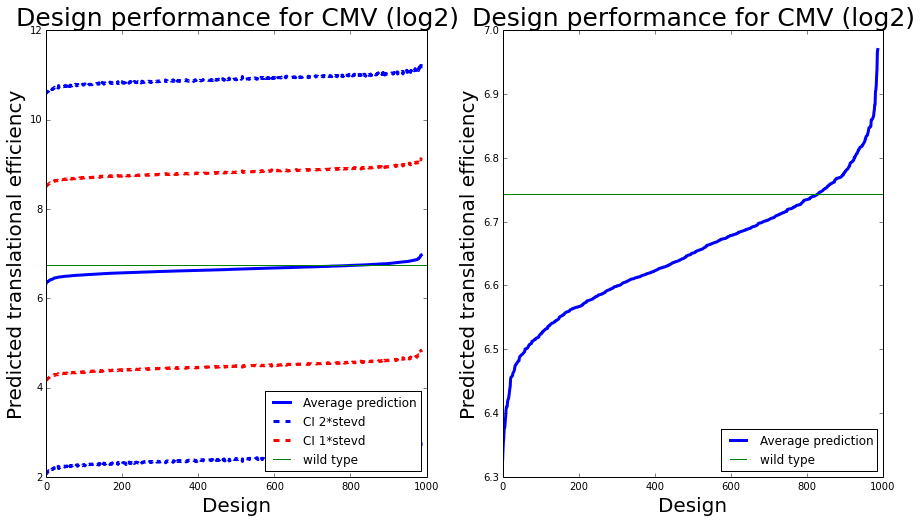

In [37]:
## Make plot to rank the genes
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(Mscore_translation[order_translation,0], linewidth=3,label='Average prediction')
plt.plot(Mscore_translation[order_translation,0]+1.96*Mscore_translation[order_translation,1],'b--', linewidth=3,label='CI 2*stevd')
plt.plot(Mscore_translation[order_translation,0]-1.96*Mscore_translation[order_translation,1],'b--', linewidth=3)
plt.plot(Mscore_translation[order_translation,0]+Mscore_translation[order_translation,1],'r--', linewidth=3,label='CI 1*stevd')
plt.plot(Mscore_translation[order_translation,0]-Mscore_translation[order_translation,1],'r--', linewidth=3)
plt.axhline(y=prediction_translation_original[0],color='g',label = 'wild type')
plt.legend(loc = 4)

plt.title('Design performance for CMV (log2)',fontsize=25)
plt.xlabel('Design',fontsize=20)
plt.ylabel('Predicted translational efficiency',fontsize=20)


plt.subplot(122)
plt.plot(Mscore_translation[order_translation,0], linewidth=3,label='Average prediction')
plt.title('Design performance for CMV (log2)',fontsize=25)
plt.xlabel('Design',fontsize=20)
plt.ylabel('Predicted translational efficiency',fontsize=20)
plt.axhline(y=prediction_translation_original[0],color='g',label = 'wild type')
plt.legend(loc = 4)


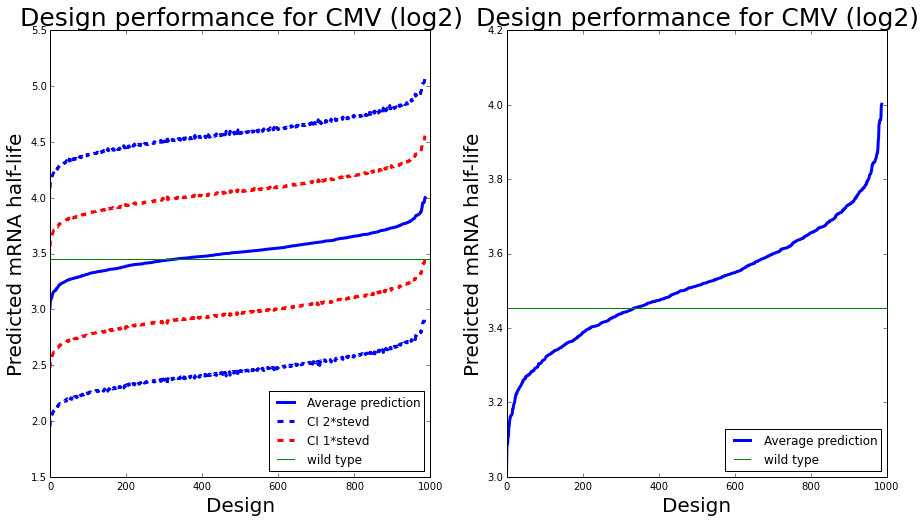

In [39]:
## Make plot to rank the genes
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(Mscore_mrna_stability[order_mrna_stability,0], linewidth=3,label='Average prediction')
plt.plot(Mscore_mrna_stability[order_mrna_stability,0]+1.96*Mscore_mrna_stability[order_mrna_stability,1],'b--', linewidth=3,label='CI 2*stevd')
plt.plot(Mscore_mrna_stability[order_mrna_stability,0]-1.96*Mscore_mrna_stability[order_mrna_stability,1],'b--', linewidth=3)
plt.plot(Mscore_mrna_stability[order_mrna_stability,0]+Mscore_mrna_stability[order_mrna_stability,1],'r--', linewidth=3,label='CI 1*stevd')
plt.plot(Mscore_mrna_stability[order_mrna_stability,0]-Mscore_mrna_stability[order_mrna_stability,1],'r--', linewidth=3)
plt.axhline(y=prediction_mrna_stability_original[0],color='g',label = 'wild type')
plt.legend(loc = 4)

plt.title('Design performance for CMV (log2)',fontsize=25)
plt.xlabel('Design',fontsize=20)
plt.ylabel('Predicted mRNA half-life',fontsize=20)


plt.subplot(122)
plt.plot(Mscore_mrna_stability[order_mrna_stability,0], linewidth=3,label='Average prediction')
plt.title('Design performance for CMV (log2)',fontsize=25)
plt.xlabel('Design',fontsize=20)
plt.ylabel('Predicted mRNA half-life',fontsize=20)
plt.axhline(y=prediction_mrna_stability_original[0],color='g',label = 'wild type')
plt.legend(loc = 4)

# 6. Conclusions

* Two models, for translational efficiency and mRNA stability based on 267 gene featues (+4096 from the codon context).


* The model for translational efficiency is more accurate than the model for mRNA stability.


* The features that affect the most the translational efficiency are:
 * (+) free folding energy.
 * (+) number of codons.
 * (+) A.
 * (-) total GC content.
 * (-) Codon adaptation index.
 * (-) GC content in the second codon position.


* The features that affect the most the mRNA stability are:
 * (+) total GC content.
 * (+) Codon adaptation index.
 * (+) number of codons.
 * (-) GC ratio.
 * (-) Relative codon usage bias.
 * (-) CGC. 
 

* In both models the most relevant part of the gene to control translation and mRNA stability is the coding region, although the most relevant feature is the total GC content.


* Given a protein to produce we can use the models to prodice recombinant genes with certain properties. it seems, however that translational efficiency and mRNA stability are two opposite goals that are difficoult to optimize simultaneously (features that increase one decrease the other). A compromise solution to design synthetic genes is to fix one, the mRNA stability, for instance, and optimize the other.

